<a href="https://colab.research.google.com/github/Anastasia-Makarova/DATA_homeworks/blob/main/HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Вирішення задачі классифікації активності людини за допомогою акселерометра

**1. Завантаження бібліотек**

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #MinMaxScaler
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

**2. Завантаження даних**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/My Drive/DATA homeworks/05/data"

In [4]:
activities = os.listdir(data_path)

In [5]:
activities

['running', 'idle', 'walking', 'stairs']

In [6]:
data_collections = []

for index, activity in enumerate(activities, start=1):
    activity_path = Path(data_path) / activity
    csv_files = list(activity_path.glob('*.csv'))
    df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
    df['activity'] = activity
    data_collections.append(df)

data = pd.concat(data_collections, ignore_index=True)
data

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,-0.167594,-16.026787,-3.059790,running
1,15.365987,27.562050,4.060566,running
2,-6.301539,7.240066,-3.122039,running
3,3.543419,26.139894,-6.995857,running
4,4.477157,-24.899698,5.822699,running
...,...,...,...,...
194155,-0.761356,-9.203311,-2.178723,stairs
194156,-1.278504,-4.141969,0.253785,stairs
194157,-0.330400,-6.105214,-3.284845,stairs
194158,1.455675,-7.479486,-3.864241,stairs


In [7]:
X = data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = data['activity']

In [8]:
X

,accelerometer_X,accelerometer_Y,accelerometer_Z
0,-0.167594,-16.026787,-3.059790
1,15.365987,27.562050,4.060566
2,-6.301539,7.240066,-3.122039
3,3.543419,26.139894,-6.995857
4,4.477157,-24.899698,5.822699
...,...,...,...
194155,-0.761356,-9.203311,-2.178723
194156,-1.278504,-4.141969,0.253785
194157,-0.330400,-6.105214,-3.284845
194158,1.455675,-7.479486,-3.864241


In [9]:
y = pd.DataFrame(y, columns=['activity'])
y

,activity
0,running
1,running
2,running
3,running
4,running
...,...
194155,stairs
194156,stairs
194157,stairs
194158,stairs


**3. Розрахунок часових ознак**

In [10]:
def mean(x):
    return x.mean()

def std(x):
    return x.std()

def max_value(x):
    return x.max()

def min_value(x):
    return x.min()

def rms(x):
    return np.sqrt((x ** 2).mean())

def peak_to_peak(x):
    return x.max() - x.min()

def autocorrelation(x):
    lag = 1
    corr = np.correlate(x, x[lag:], mode='full')[lag]
    return corr / x.std() ** 2

X_new = []
for signal in X[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].to_numpy():
    features = [
        mean(signal),
        std(signal),
        max_value(signal),
        min_value(signal),
        rms(signal),
        peak_to_peak(signal),
        autocorrelation(signal)
    ]
    X_new.append(features)

X_new = pd.DataFrame(X_new, columns=['mean',
                                     'std',
                                     'max',
                                     'min',
                                     'rms',
                                     'peak_to_peak',
                                     'autocorrelation'
                                     ]
                     )

In [11]:
X_new

,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-6.418057,6.896229,-0.167594,-16.026787,9.420692,15.859193,1.087611
1,15.662868,9.596737,27.562050,4.060566,18.369071,23.501484,5.813800
2,-0.727837,5.781748,7.240066,-6.301539,5.827380,13.541605,-2.040986
3,7.562485,13.822908,26.139894,-6.995857,15.756394,33.135751,-0.472314
4,-4.866614,14.176176,5.822699,-24.899698,14.988259,30.722397,-1.276166
...,...,...,...,...,...,...,...
194155,-4.047797,3.691136,-0.761356,-9.203311,5.478060,8.441955,1.986017
194156,-1.722229,1.821782,0.253785,-4.141969,2.506983,4.395754,1.278848
194157,-3.240153,2.357770,-0.330400,-6.105214,4.007202,5.774814,3.970414
194158,-3.296017,3.669826,1.455675,-7.479486,4.932682,8.935161,1.337640


In [12]:
X = pd.concat([X, X_new], axis=1)

In [13]:
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-0.167594,-16.026787,-3.059790,-6.418057,6.896229,-0.167594,-16.026787,9.420692,15.859193,1.087611
1,15.365987,27.562050,4.060566,15.662868,9.596737,27.562050,4.060566,18.369071,23.501484,5.813800
2,-6.301539,7.240066,-3.122039,-0.727837,5.781748,7.240066,-6.301539,5.827380,13.541605,-2.040986
3,3.543419,26.139894,-6.995857,7.562485,13.822908,26.139894,-6.995857,15.756394,33.135751,-0.472314
4,4.477157,-24.899698,5.822699,-4.866614,14.176176,5.822699,-24.899698,14.988259,30.722397,-1.276166
...,...,...,...,...,...,...,...,...,...,...
194155,-0.761356,-9.203311,-2.178723,-4.047797,3.691136,-0.761356,-9.203311,5.478060,8.441955,1.986017
194156,-1.278504,-4.141969,0.253785,-1.722229,1.821782,0.253785,-4.141969,2.506983,4.395754,1.278848
194157,-0.330400,-6.105214,-3.284845,-3.240153,2.357770,-0.330400,-6.105214,4.007202,5.774814,3.970414
194158,1.455675,-7.479486,-3.864241,-3.296017,3.669826,1.455675,-7.479486,4.932682,8.935161,1.337640


**4.  EDA**

In [14]:
scaler = StandardScaler() #MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns.values.tolist())
X

,accelerometer_X,accelerometer_Y,accelerometer_Z,mean,std,max,min,rms,peak_to_peak,autocorrelation
0,-0.249395,-1.413716,-0.676669,-1.134603,0.436399,-0.934877,-1.557344,0.212401,0.411138,-0.016700
1,1.598314,2.080679,0.313468,1.920980,1.284933,2.141996,1.162730,1.950224,1.432811,-0.012711
2,-0.979024,0.451523,-0.685325,-0.347184,0.086214,-0.112925,-0.240426,-0.485439,0.101307,-0.019342
3,0.192027,1.966669,-1.224008,0.800040,2.612851,1.984194,-0.334445,1.442828,2.720785,-0.018017
4,0.303095,-2.125032,0.558506,-0.919913,2.723853,-0.270196,-2.758846,1.293652,2.398152,-0.018696
...,...,...,...,...,...,...,...,...,...,...
194155,-0.320023,-0.866697,-0.554150,-0.806604,-0.570683,-1.000761,-0.633362,-0.553279,-0.580448,-0.015942
194156,-0.381538,-0.460943,-0.215892,-0.484789,-1.158059,-0.888121,0.052006,-1.130278,-1.121372,-0.016539
194157,-0.268761,-0.618331,-0.707964,-0.694841,-0.989644,-0.952942,-0.213841,-0.838928,-0.937010,-0.014267
194158,-0.056309,-0.728502,-0.788534,-0.702572,-0.577379,-0.754760,-0.399935,-0.659194,-0.514513,-0.016489


**4.1. Кореляція фіч між собою**

<Axes: >

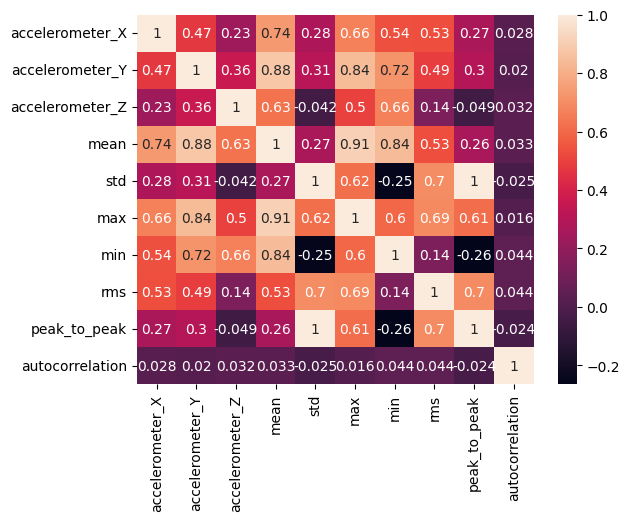

In [15]:
corr_x = X.corr()
sns.heatmap (corr_x, annot=True)

In [16]:
X = X.drop('peak_to_peak', axis=1)

In [17]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_new = labelencoder.fit_transform(y.values)
y_new

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 2, 2, 2])

**5. Відбір фіч**

In [18]:
f_stats, p_values = f_regression(X, y_new)
for i, (feature, f_stat, p_value) in enumerate(zip(range(X.shape[1]), f_stats, p_values)):
    print(f"Feature {i}: F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

selected_features = np.where(p_values < 0.05)[0]
print("Selected Features:", selected_features)

Feature 0: F-statistic=14575.6782, p-value=0.0000
Feature 1: F-statistic=69965.1391, p-value=0.0000
Feature 2: F-statistic=32878.2027, p-value=0.0000
Feature 3: F-statistic=73816.9461, p-value=0.0000
Feature 4: F-statistic=592.2295, p-value=0.0000
Feature 5: F-statistic=55144.2910, p-value=0.0000
Feature 6: F-statistic=76095.5716, p-value=0.0000
Feature 7: F-statistic=139.8314, p-value=0.0000
Feature 8: F-statistic=0.0002, p-value=0.9901
Selected Features: [0 1 2 3 4 5 6 7]


In [19]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

sfm = SelectFromModel(rf_model, prefit=True)
X_rf_selected = sfm.transform(X)

print("Original number of features:", X.shape[1])
print("Selected number of features:", X_rf_selected.shape[1])

<ipython-input-19-aed16d3770f3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X, y)


Original number of features: 9
Selected number of features: 4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [20]:
X_rf_selected

array([[-1.41371568, -0.67666886, -1.13460347, -0.93487724],
       [ 2.08067948,  0.31346828,  1.92098004,  2.14199626],
       [ 0.45152285, -0.68532503, -0.34718439, -0.11292537],
       ...,
       [-0.61833092, -0.70796439, -0.69484149, -0.95294215],
       [-0.72850247, -0.78853361, -0.70257206, -0.75475977],
       [-0.86247413, -0.82848531, -0.78562104, -0.73722625]])

**6. Розподілення даних на навчальну і тестову выбірки**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

In [22]:
X_rf_selected_train, X_rf_selected_test, y_train, y_test = train_test_split(X_rf_selected, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    )

 **7. Навчання та оцінка моделей**


**7.1. SVM**

**7.1.1. Усі фічі**

In [23]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print('Отчет о классификации SVM with time domain features:')
print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Отчет о классификации SVM with time domain features:
              precision    recall  f1-score   support

        idle       0.97      0.98      0.98      6234
     running       0.93      0.91      0.92     20508
      stairs       1.00      0.00      0.00       990
     walking       0.81      0.90      0.85     11100

    accuracy                           0.90     38832
   macro avg       0.93      0.70      0.69     38832
weighted avg       0.90      0.90      0.89     38832



In [24]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_svm

array([[ 6138,    80,     0,    16],
       [  190, 18700,     0,  1618],
       [    6,   289,     2,   693],
       [   20,  1085,     0,  9995]])

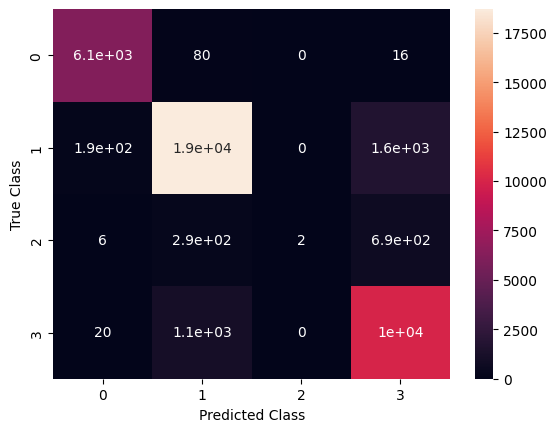

In [43]:
sns.heatmap(conf_matrix_svm, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.1.2 Фічі з f-regression**

In [25]:
svm_model = SVC(C=1.0,
                probability = True,
                tol = 0.0001,
                random_state=42)
svm_model.fit(X_rf_selected_train, y_train)

y_pred_svm_select = svm_model.predict(X_rf_selected_test)

print('Отчет о классификации SVM with time domain features (f-regression selection):')
print(classification_report(y_test, y_pred_svm_select))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Отчет о классификации SVM with time domain features (f-regression selection):
              precision    recall  f1-score   support

        idle       0.95      0.99      0.97      6234
     running       0.93      0.90      0.91     20508
      stairs       1.00      0.00      0.00       990
     walking       0.80      0.90      0.85     11100

    accuracy                           0.89     38832
   macro avg       0.92      0.70      0.68     38832
weighted avg       0.90      0.89      0.88     38832



In [26]:
conf_matrix_svm_select = confusion_matrix(y_test, y_pred_svm_select)
conf_matrix_svm_select

array([[ 6145,    71,     0,    18],
       [  296, 18367,     0,  1845],
       [   12,   268,     2,   708],
       [   48,  1015,     0, 10037]])

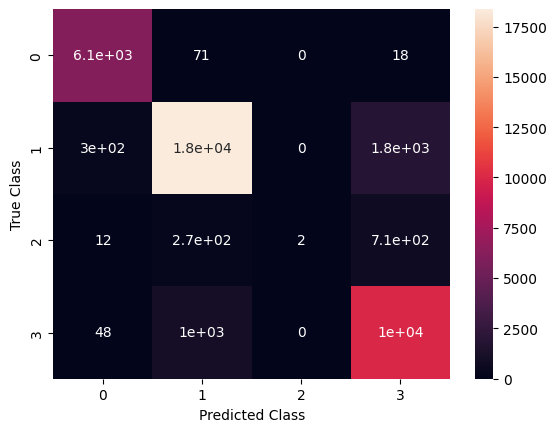

In [42]:
sns.heatmap(conf_matrix_svm_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2. Random Forest**

**7.2.1 Усі фічі**

**7.2.1.1 max_depth=3**

In [34]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=3,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_3 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_3))

<ipython-input-34-d28558a1cebb>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Отчет о классификации Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        idle       0.97      0.96      0.97      6234
     running       0.89      0.91      0.90     20508
      stairs       0.00      0.00      0.00       990
     walking       0.79      0.84      0.82     11100

    accuracy                           0.88     38832
   macro avg       0.67      0.68      0.67     38832
weighted avg       0.85      0.88      0.86     38832



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
conf_matrix_rf_3 = confusion_matrix(y_test, y_pred_rf_3)
conf_matrix_rf_3

array([[ 5982,   238,     0,    14],
       [  131, 18648,     0,  1729],
       [    3,   304,     0,   683],
       [   20,  1724,     0,  9356]])

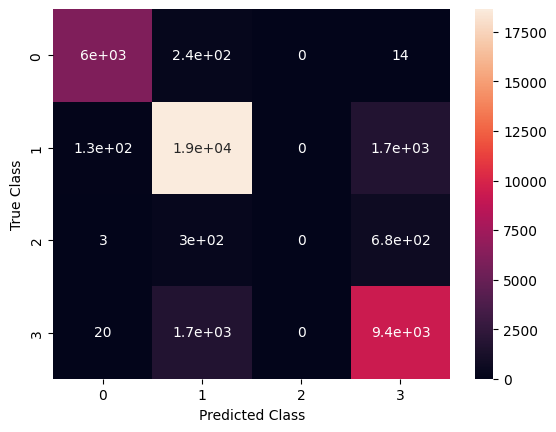

In [41]:
sns.heatmap(conf_matrix_rf_3, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2.1.2 max_depth=15**

In [36]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_train, y_train)

y_pred_rf_15 = rf_model.predict(X_test)

print('Отчет о классификации Random Forest:')
print(classification_report(y_test, y_pred_rf_15))

<ipython-input-36-62d025f61e98>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Отчет о классификации Random Forest:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20508
      stairs       1.00      0.80      0.89       990
     walking       0.96      1.00      0.98     11100

    accuracy                           0.99     38832
   macro avg       0.99      0.95      0.97     38832
weighted avg       0.99      0.99      0.99     38832



In [37]:
conf_matrix_rf_15 = confusion_matrix(y_test, y_pred_rf_15)
conf_matrix_rf_15

array([[ 6232,     0,     0,     2],
       [    3, 20261,     0,   244],
       [    1,     8,   795,   186],
       [    0,     6,     0, 11094]])

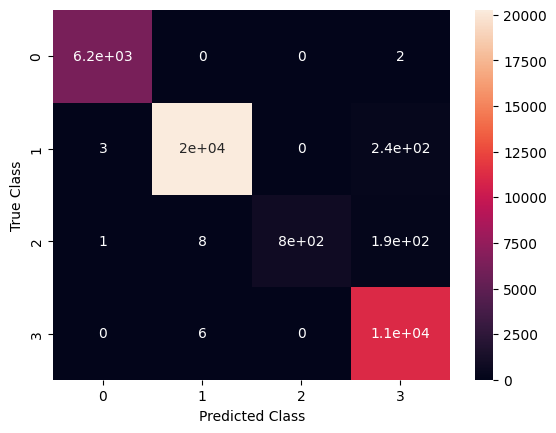

In [40]:
sns.heatmap(conf_matrix_rf_15, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()

**7.2.2 фічі з SelectFromMode**

In [29]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  random_state=42,
                                  )

rf_model.fit(X_rf_selected_train, y_train)

y_pred_rf_select = rf_model.predict(X_rf_selected_test)

print('Отчет о классификации Random Forest (SelectFromModel Features):')
print(classification_report(y_test, y_pred_rf_select))

<ipython-input-29-fadbeab2fbf3>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_rf_selected_train, y_train)


Отчет о классификации Random Forest (SelectFromModel Features):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6234
     running       1.00      0.99      0.99     20508
      stairs       1.00      0.83      0.91       990
     walking       0.97      1.00      0.98     11100

    accuracy                           0.99     38832
   macro avg       0.99      0.96      0.97     38832
weighted avg       0.99      0.99      0.99     38832



In [30]:
conf_matrix_rf_select = confusion_matrix(y_test, y_pred_rf_select)
conf_matrix_rf_select

array([[ 6231,     3,     0,     0],
       [   17, 20307,     0,   184],
       [    3,    11,   824,   152],
       [    9,     9,     0, 11082]])

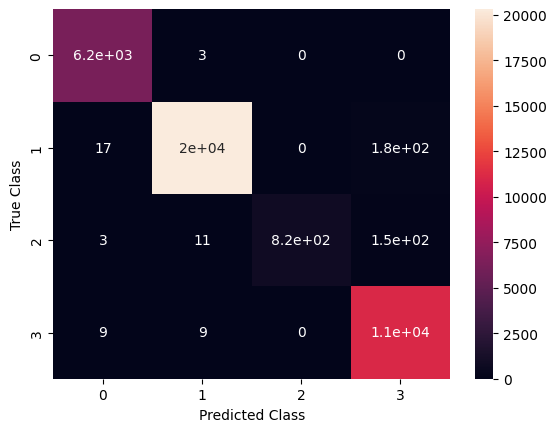

In [39]:
sns.heatmap(conf_matrix_rf_select, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.show()